## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Import Packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [2]:
class Line():
    '''Stores the ploty of the previous frame'''
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        self.last_left_fit = None
        self.last_right_fit=None
        self.last_ploty=None
        
    def set_detected(self,v):
        self.detected=v
    def get_detected(self):
        return self.detected
    
    def get_last_left_fit(self):
        return self.last_left_fit
    def set_last_left_fit(self,left_fit):
        self.last_left_fit=left_fit
    def get_last_right_fit(self):
        return self.last_right_fit
    def set_last_right_fit(self,right_fit):
        self.last_right_fit=right_fit
    def get_last_ploty(self):
        return self.last_ploty
    def set_last_ploty(self,ploty):
        self.last_ploty=ploty

In [3]:
def print2images(img1,img2,name1='Image1',name2='Image2'):
    '''Print two images next to each other:'''
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(name1, fontsize=50)
    ax2.imshow(img2)
    ax2.set_title(name2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Step 1: Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [4]:
# Function that uses the calibration images and returns the object points and image points to calebrate an image
def calibrate():
    #reading in the path to callibration images
    images = glob.glob("camera_cal/calibration*.jpg")

    nx = 9 #inside corners x
    ny = 6 #inside corners y

    objectpoints=[] #3D Points in real world
    imagespoints=[] #2D Points in image plane

    #Reshaping
    objp=np.zeros((ny*nx,3), np.float32)
    objp[:,:2]=np.mgrid[0:nx,0:ny].T.reshape(-1,2)


    for fname in images:
        img = cv2.imread(fname) 
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret: #If cornes found add images points & object points
            imagespoints.append(corners)
            objectpoints.append(objp)
    return [objectpoints,imagespoints]

### Step 2: Apply a distortion correction to raw images.

In [5]:
# Function that takes an image performs the camera calibration, image distortion correction and 
# returns the undistorted image
def image_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

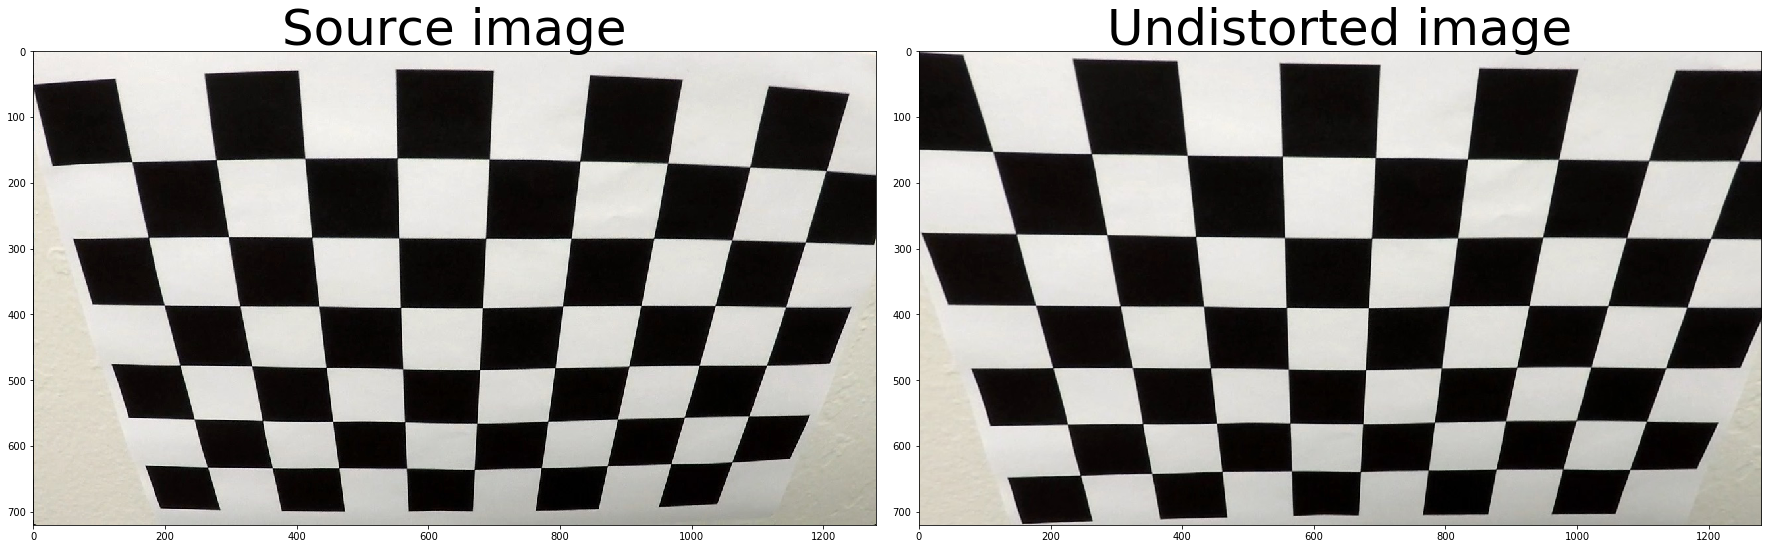

In [6]:
source_cal = mpimg.imread('camera_cal/calibration2.jpg')
objectpoints, imagespoints=calibrate()
example_undistorted=image_undistort(source_cal, objectpoints, imagespoints)
print2images(source_cal,example_undistorted,name1='Source image',name2='Undistorted image')

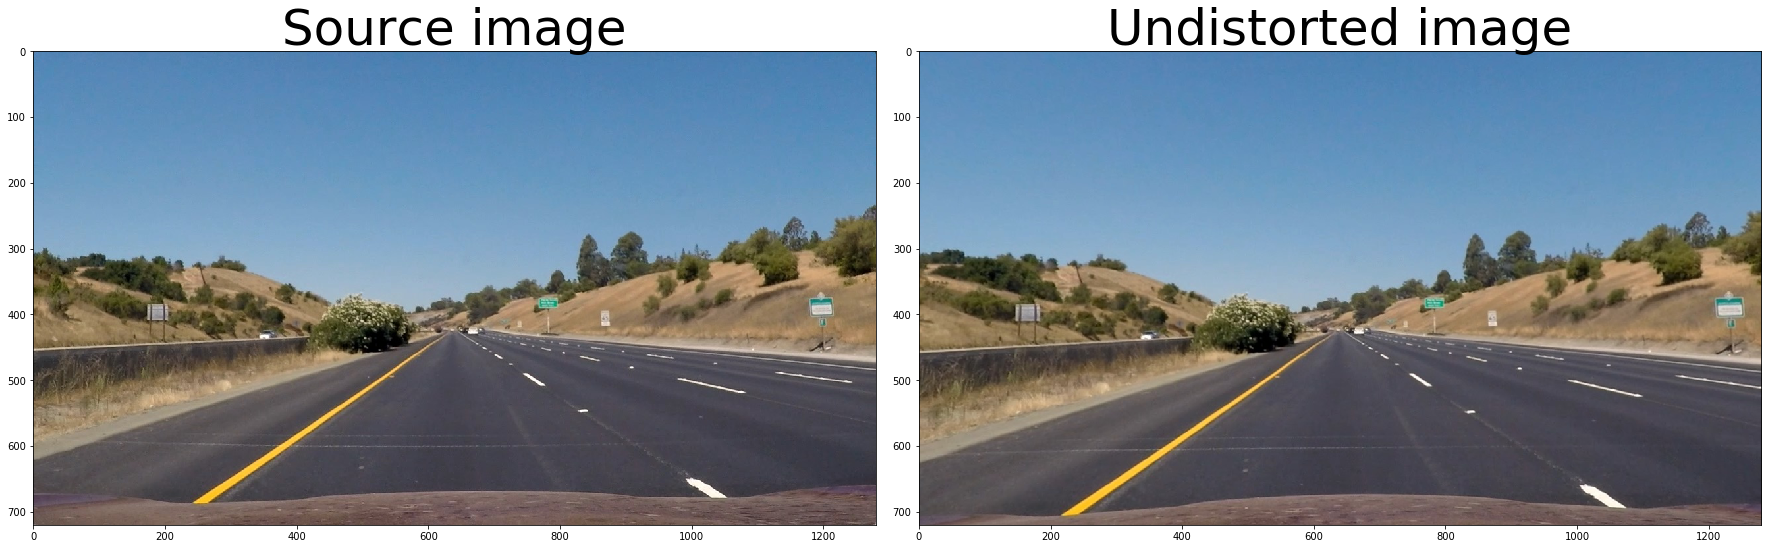

In [7]:
source_cal = mpimg.imread('test_images/straight_lines1.jpg')
objectpoints, imagespoints=calibrate()
example_undistorted=image_undistort(source_cal, objectpoints, imagespoints)
print2images(source_cal,example_undistorted,name1='Source image',name2='Undistorted image')

### Step 3: Use color transforms, gradients, etc., to create a thresholded binary image.

In [8]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    abs_sobel = np.absolute(sobel)
    
    # Do that so that numbers are in 8bit (0-255)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    sbinary = np.zeros_like(scaled_sobel)
    #Only points which fullfill these requirements will be coloured in the mask
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return sbinary #mask

def mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100)):
    'Calculate gradient magnitude'
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    gradmag = np.sqrt(sobelx**2 + sobely**2)

    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    return binary_output #mask

def dir_threshold(img, sobel_kernel=3, thresh=(0.7, 1.3)):
    # Calculate gradient direction
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the gradient direction
    # An orientation of 0 implies a vertical line -> 0, np.pi/2
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return binary_output #mask

In [9]:
def threshold_pipeline(image, s_thresh=(170, 220), sx_thresh=(20, 100), sy_thresh=(20, 100), m_thresh=(30, 100), dir_thresh=(0.7, 1.3)):
    img = np.copy(image)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #TODO: How could the l channel be usefull? Should I use it for the x gradient?
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # TODO: I can further optimize my thershold with the functions above
    # Threshold color channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= 145) & (l_channel <= 155)] = 1
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    combined_binary = np.zeros_like(s_channel)
    gradx=abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=sx_thresh)
    grady=abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh=sy_thresh)
    mag_binary=mag_thresh(img, sobel_kernel=3, mag_thresh=m_thresh)
    dir_binary=dir_threshold(img, sobel_kernel=3, thresh=dir_thresh)
    combined_binary[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (gradx == 1) &(s_binary == 1)| (s_binary==1)] = 255
    
    
    # Visualization
    # Stack each channel to get a image where I can see the influences of the diffrent masks in green and blue
    color_binary = np.dstack(( np.zeros_like(gradx), s_binary, gradx)) * 255
    
    return combined_binary
    

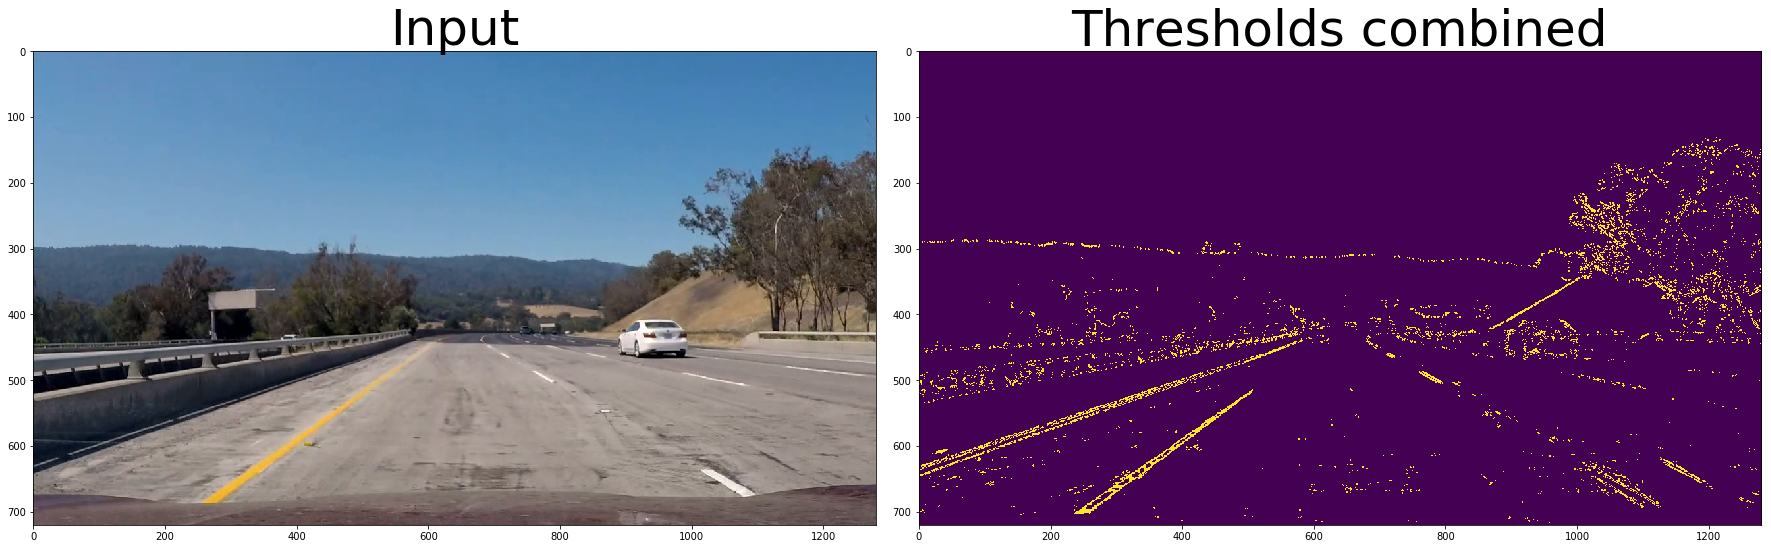

In [10]:
a3=VideoFileClip('project_video.mp4').get_frame(23)
threshold_image_undist=image_undistort(a3, objectpoints, imagespoints)
threshold_image=threshold_pipeline(threshold_image_undist)
print2images(a3,threshold_image,name1='Input',name2='Thresholds combined')

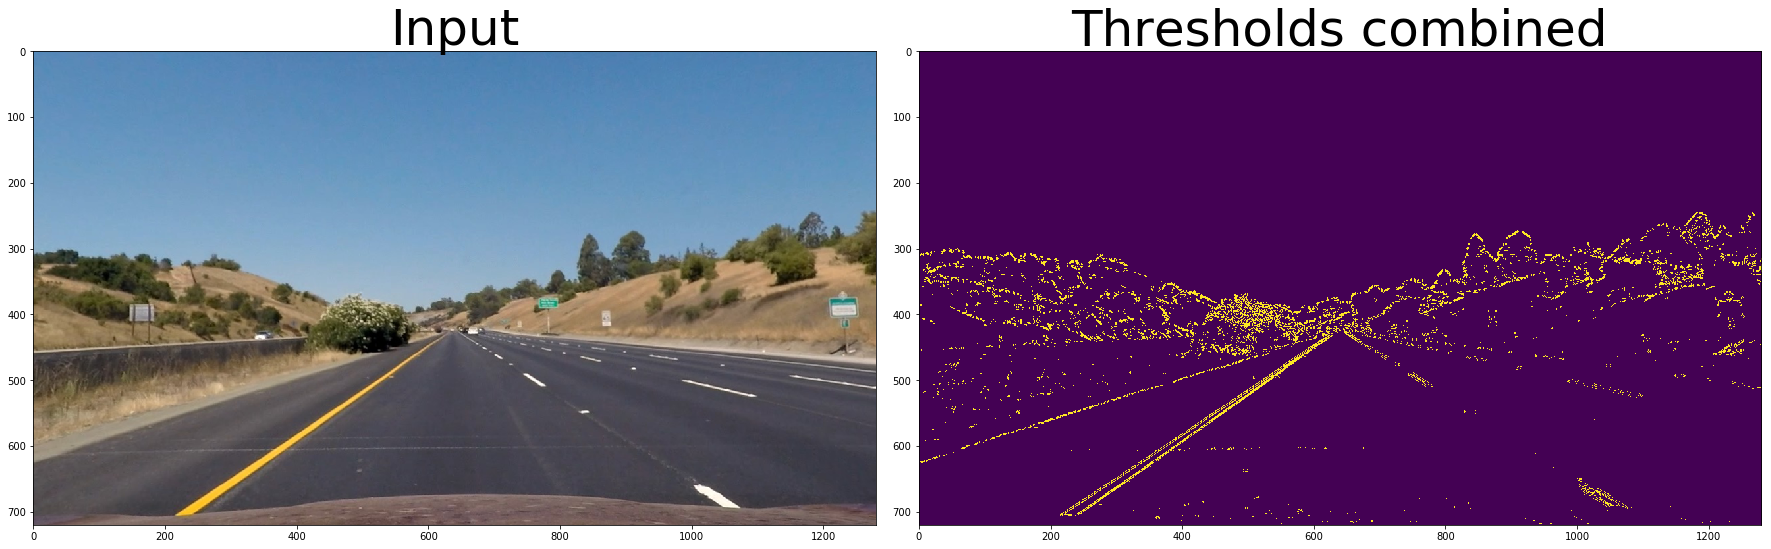

In [11]:
threshold_image_input=mpimg.imread('test_images/straight_lines1.jpg')
threshold_image_undist=image_undistort(threshold_image_input, objectpoints, imagespoints)
threshold_image=threshold_pipeline(threshold_image_undist)
print2images(threshold_image_undist,threshold_image,name1='Input',name2='Thresholds combined')

### Step 4: Apply a perspective transform to rectify binary image ("birds-eye view")

In [12]:
def give_points(img):
    src=np.float32([[585,460],[695,460],[1127,img.shape[0]],[203,img.shape[0]]])
    dst=np.float32([[320,0],[960,0],[960,img.shape[0]],[320,img.shape[0]]])
    # Some other approximations. Since I hardcoded the values they may not be the best
    '''src=np.float32([[595,460],[675,460],[900,img.shape[0]],[300,img.shape[0]]])
    dst=np.float32([[300,0],[900,0],[900,img.shape[0]],[300,img.shape[0]]])'''
    return src, dst
def warper(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
    return M, warped

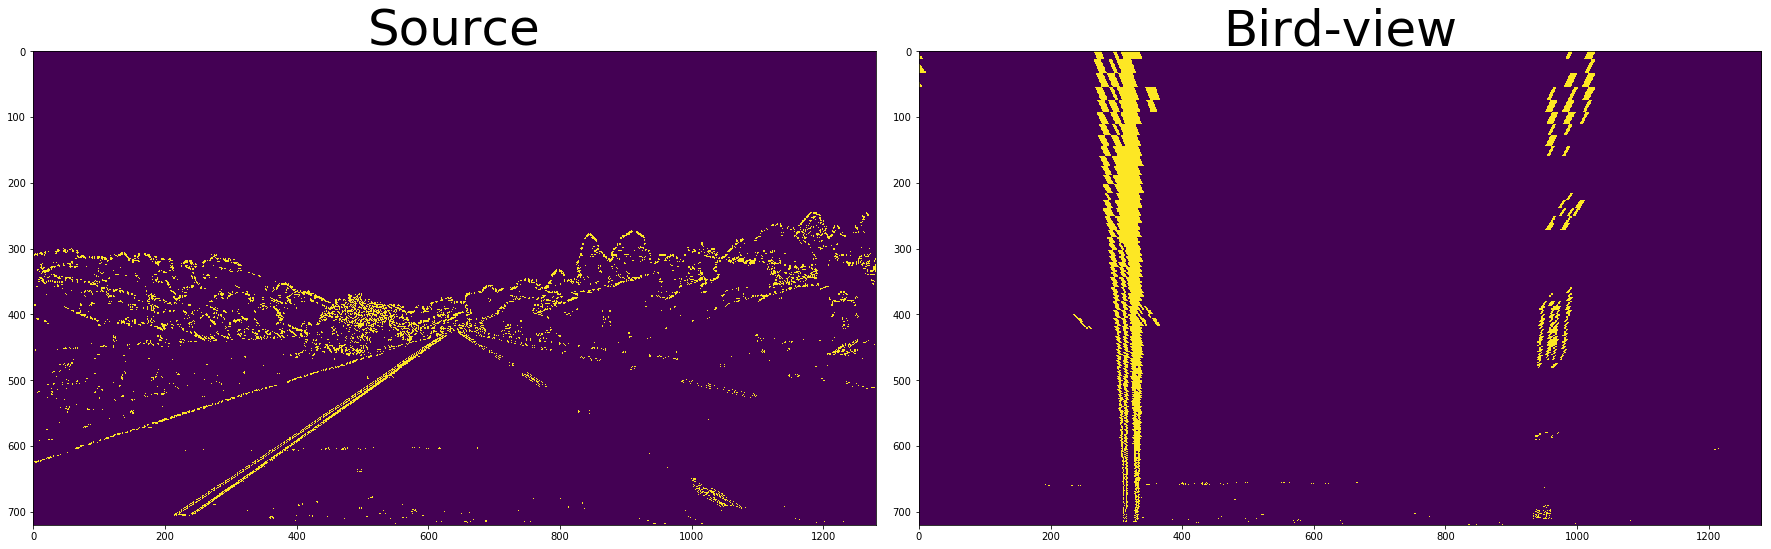

In [13]:
src, dst = give_points(threshold_image)
M, binary_warped_example = warper(threshold_image,src,dst)
print2images(threshold_image,binary_warped_example,name1='Source',name2='Bird-view')

### Step 5: Detect lane pixels and fit to find the lane boundary.

In [14]:
def find_lane_pixels(binary_warped, nwindows = 22, margin = 65, minpix = 50):
    '''
    binary_warped takes in a binary warped images
    nwindows is the  number of sliding windows
    margin sets the width of the windows +/- margin
    minpix = 50 sets minimum number of pixels found to recenter window
    Returns left and right line pixel positions
    '''
    # Take a histogram of the bottom half of the image
    button_half=binary_warped[binary_warped.shape[0]//2:,:]
    histogram = np.sum(button_half, axis=0)
    
    # Visualization of results needs to have 3 dimensions
    # out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halfes of the histogram
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    #get the y-axis
    # Array filled with 0 where nothing is and when there is a pixels the array contains the y-indizes
    nonzeroy = np.array(nonzero[0])
    #get the x-axis
    nonzerox = np.array(nonzero[1])
   
    
    # Current positions
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Visualization
        # cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        # (win_xleft_high,win_y_high),(0,255,0), 2) 
        # cv2.rectangle(out_img,(win_xright_low,win_y_low),
        # (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # Recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    # Join a sequence of arrays along an existing axis
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

def fit_polynomial(binary_warped, leftx, lefty, rightx, righty):
    
    # Second order polynomial
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # np.linspace returns evenly spaced numbers over a specified interval
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    ## Visualization ##
    # Colors in the left and right lane regions
    # out_img[lefty, leftx] = [255, 0, 0]
    # out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    # plt.plot(left_fitx, ploty, color='yellow')
    # plt.plot(right_fitx, ploty, color='yellow')

    return left_fitx, right_fitx, ploty, left_fit, right_fit

In [15]:
def search_around_poly(binary_warped, left_fit, right_fit, margin = 50):
   
    # Take activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Sets the area of search based on activated x-values
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty, left_fit, right_fit = fit_polynomial(binary_warped, leftx, lefty, rightx, righty)
    return left_fitx, right_fitx, ploty, left_fit, right_fit

### Step 6: Determine the curvature of the lane and vehicle position with respect to center.

In [16]:
def offset(left_fitx, right_fitx, image):
    xm_per_pix=3.7/800
    # Point of the camera
    middle = image.shape[1]//2
        
    # Car position within lines
    pos_car = (left_fitx[-1] + right_fitx[-1])/2
    
    #offset 
    offset = (middle - pos_car) * xm_per_pix

    return offset

In [17]:
def curvature(left_fitx, right_fitx, ploty):
    # Curvature of polynomial functions in meters.
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700
    
    # Reverse to match top-to-bottom in y
    left_fitx = left_fitx[::-1]  
    right_fitx = right_fitx[::-1] 

    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Define y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Radius of curvature (last lesson)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

In [18]:
def draw(image, undistort_image, binary_warped, left_fitx, right_fitx, ploty, M):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    v, Minv=cv2.invert(M)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistort_image, 1, newwarp, 0.3, 0)
    
    return result

In [19]:
objectpoints, imagespoints=calibrate()
last=Line()
def image_pip(image):
    undistort_image=image_undistort(image, objectpoints, imagespoints)
    edges_image=threshold_pipeline(undistort_image)
    src, dst = give_points(image)
    M, binary_warped = warper(edges_image,src,dst)
    #checks if there was a frame before the current one
    if last.get_detected():
        left_fit=last.get_last_left_fit()
        right_fit=last.get_last_right_fit()
        left_fitx, right_fitx, ploty, left_fit, right_fit = search_around_poly(binary_warped, left_fit, right_fit)
    else:
        leftx, lefty, rightx, righty = find_lane_pixels(binary_warped)
        left_fitx, right_fitx, ploty, left_fit, right_fit = fit_polynomial(binary_warped, leftx, lefty, rightx, righty)
        last.set_detected(True)
    last.set_last_left_fit(left_fit)
    last.set_last_right_fit(right_fit)
    last.set_last_ploty(ploty)
    result=draw(image, undistort_image, binary_warped, left_fitx, right_fitx, ploty, M)
    left_curverad, right_curverad = curvature(left_fitx, right_fitx, ploty)
    ofs=offset(left_fitx, right_fitx, image)
    
     # Display curvature
    cv2.putText(result, 'Left line curvature: {:.2f} m'.format(left_curverad), (100, 60), cv2.FONT_HERSHEY_PLAIN, 3.5, (255,255,255), 4)
    cv2.putText(result, 'Right line curvature: {:.2f} m'.format(right_curverad), (100, 110), cv2.FONT_HERSHEY_PLAIN, 3.5, (255,255,255), 4)
    
    # Display offset
    cv2.putText(result, 'Car offset: {:.2f} m'.format(ofs), (100, 160), cv2.FONT_HERSHEY_PLAIN, 3.5, (255,255,255), 4)

    return result



### Example on a picture

image=mpimg.imread('test_images/test1.jpg')
plt.imshow(image_pip(image))

### Video Pipline

In [20]:
def process_image(image):
    return image_pip(image)

In [21]:
challenge_output = 'output_images/challenge1.mp4'
clip3 = VideoFileClip('project_video.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video output_images/challenge1.mp4
[MoviePy] Writing video output_images/challenge1.mp4


100%|█████████▉| 1260/1261 [46:39<00:01,  1.37s/it]   


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/challenge1.mp4 

CPU times: user 45min 21s, sys: 1min 24s, total: 46min 46s
Wall time: 46min 41s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

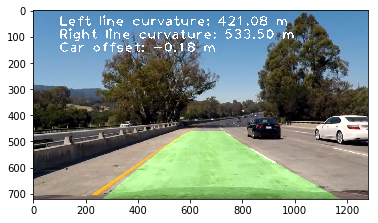

In [23]:
a1=VideoFileClip('project_video.mp4').get_frame(40.30)
a2=VideoFileClip('project_video.mp4').get_frame(41)
a3=VideoFileClip('project_video.mp4').get_frame(42)
plt.imshow(image_pip(a1))
